<a href="https://colab.research.google.com/github/roshankarumanchi/Fine-grained-dog-breed-image-classification/blob/main/Fine_Grained_Dog_Breed_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 224
BATCH_SIZE = 64


In [ ]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8WEBOP/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete8WEBOP/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

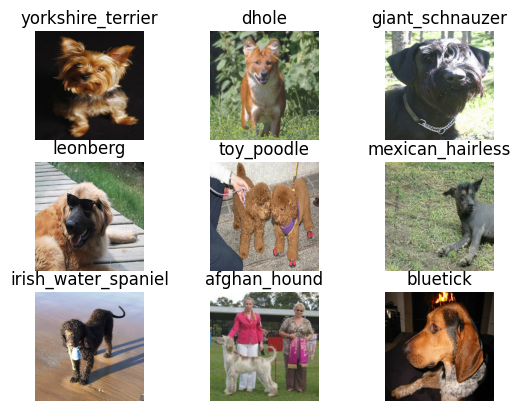

In [ ]:

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]


def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images


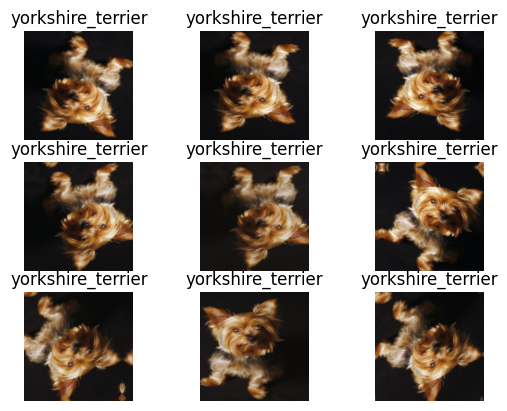

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")


In [ ]:

# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)


In [ ]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 10  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)


Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv_pad (ZeroPadding  (None, 225, 225, 3)          0         ['normalization[0

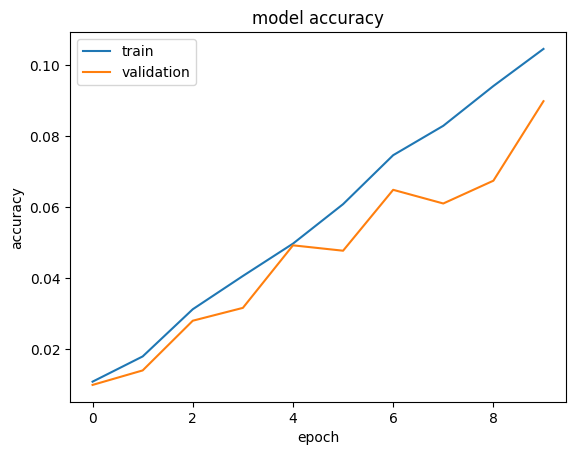

In [ ]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

In [ ]:

def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


Epoch 1/10
187/187 [==============================] - 147s 729ms/step - loss: 3.2421 - accuracy: 0.4222 - val_loss: 0.8152 - val_accuracy: 0.7604
Epoch 2/10
187/187 [==============================] - 134s 716ms/step - loss: 1.6516 - accuracy: 0.5790 - val_loss: 0.7130 - val_accuracy: 0.7832
Epoch 3/10
187/187 [==============================] - 133s 712ms/step - loss: 1.3284 - accuracy: 0.6279 - val_loss: 0.6856 - val_accuracy: 0.7878
Epoch 4/10
187/187 [==============================] - 139s 742ms/step - loss: 1.2311 - accuracy: 0.6505 - val_loss: 0.7027 - val_accuracy: 0.7870
Epoch 5/10
187/187 [==============================] - 136s 728ms/step - loss: 1.1747 - accuracy: 0.6601 - val_loss: 0.6966 - val_accuracy: 0.7943
Epoch 6/10
187/187 [==============================] - 139s 744ms/step - loss: 1.1464 - accuracy: 0.6735 - val_loss: 0.7083 - val_accuracy: 0.7933
Epoch 7/10
187/187 [==============================] - 134s 716ms/step - loss: 1.1222 - accuracy: 0.6773 - val_loss: 0.7055 -

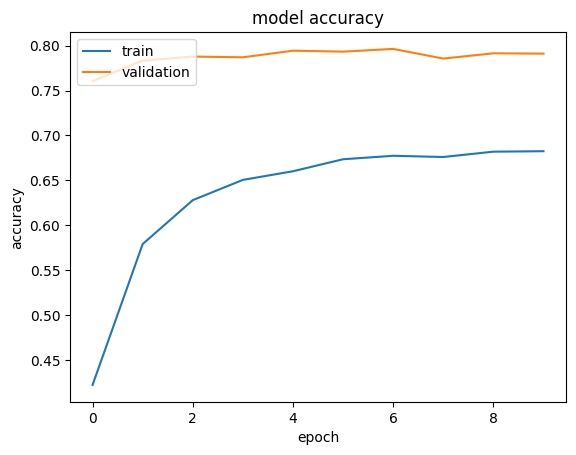

In [ ]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Epoch 1/4
187/187 [==============================] - 145s 731ms/step - loss: 0.9030 - accuracy: 0.7307 - val_loss: 0.7058 - val_accuracy: 0.7992
Epoch 2/4
187/187 [==============================] - 140s 751ms/step - loss: 0.8837 - accuracy: 0.7401 - val_loss: 0.6816 - val_accuracy: 0.8048
Epoch 3/4
187/187 [==============================] - 138s 738ms/step - loss: 0.8481 - accuracy: 0.7452 - val_loss: 0.6676 - val_accuracy: 0.8085
Epoch 4/4
187/187 [==============================] - 135s 722ms/step - loss: 0.8237 - accuracy: 0.7557 - val_loss: 0.6567 - val_accuracy: 0.8122


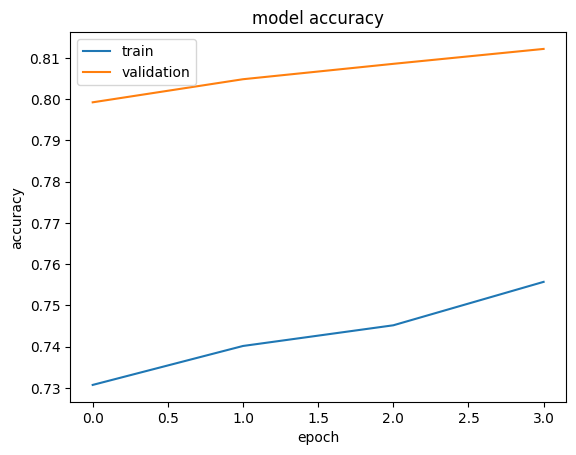

In [ ]:

def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

In [ ]:
def build_convnext_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
custom_model = build_convnext_model((IMG_SIZE, IMG_SIZE, 3), NUM_CLASSES)

In [ ]:
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 10
hist = custom_model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Epoch 1/10
187/187 [==============================] - 133s 677ms/step - loss: 13.6536 - accuracy: 0.0084 - val_loss: 4.7768 - val_accuracy: 0.0131
Epoch 2/10
187/187 [==============================] - 127s 678ms/step - loss: 4.7638 - accuracy: 0.0113 - val_loss: 4.7493 - val_accuracy: 0.0138
Epoch 3/10
187/187 [==============================] - 128s 685ms/step - loss: 4.7482 - accuracy: 0.0117 - val_loss: 4.7408 - val_accuracy: 0.0161
Epoch 4/10
187/187 [==============================] - 136s 724ms/step - loss: 4.7286 - accuracy: 0.0149 - val_loss: 4.7197 - val_accuracy: 0.0160
Epoch 5/10
187/187 [==============================] - 127s 681ms/step - loss: 4.7002 - accuracy: 0.0142 - val_loss: 4.6779 - val_accuracy: 0.0140
Epoch 6/10
187/187 [==============================] - 134s 715ms/step - loss: 4.6887 - accuracy: 0.0155 - val_loss: 4.6657 - val_accuracy: 0.0148
Epoch 7/10
187/187 [==============================] - 143s 762ms/step - loss: 4.6487 - accuracy: 0.0168 - val_loss: 4.6559 

In [ ]:
def unfreeze_custom_model(model):
    for layer in model.layers:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

unfreeze_custom_model(custom_model)

fine_tune_epochs = 5
hist = custom_model.fit(ds_train, epochs=fine_tune_epochs, validation_data=ds_test)


Epoch 1/5
187/187 [==============================] - 130s 687ms/step - loss: 4.6107 - accuracy: 0.0206 - val_loss: 4.6323 - val_accuracy: 0.0173
Epoch 2/5
187/187 [==============================] - 127s 682ms/step - loss: 4.6096 - accuracy: 0.0207 - val_loss: 4.6311 - val_accuracy: 0.0182
Epoch 3/5
187/187 [==============================] - 127s 682ms/step - loss: 4.6044 - accuracy: 0.0202 - val_loss: 4.6302 - val_accuracy: 0.0182
Epoch 4/5
187/187 [==============================] - 134s 718ms/step - loss: 4.6050 - accuracy: 0.0236 - val_loss: 4.6295 - val_accuracy: 0.0184
Epoch 5/5
187/187 [==============================] - 135s 725ms/step - loss: 4.6045 - accuracy: 0.0205 - val_loss: 4.6299 - val_accuracy: 0.0176


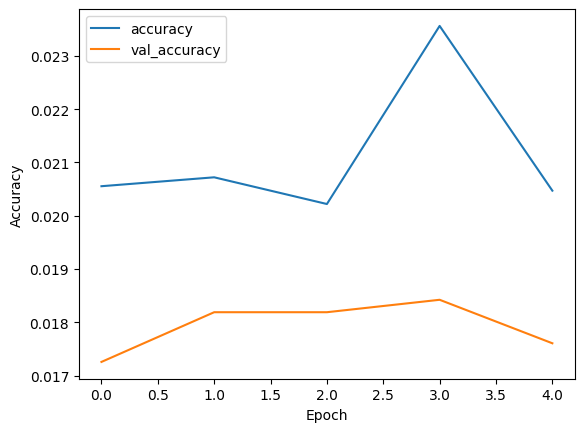

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['accuracy'], label='accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_hist(hist)


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# Assuming 'custom_model' is your trained custom model
y_true = []
y_pred = []

for images, labels in ds_test:
    predictions = custom_model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    y_true.extend(true_classes)
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
cm = confusion_matrix(y_true, y_pred)

results = pd.DataFrame({
    'Metric': ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, balanced_accuracy, precision, recall, f1]
})

print(results)
print("\nConfusion Matrix:")
print(cm)


2/2 [==============================] - 0s 19ms/step
              Metric     Score
0           Accuracy  0.017607
1  Balanced Accuracy  0.018566
2          Precision  0.012926
3             Recall  0.018566
4           F1 Score  0.010680

Confusion Matrix:
[[0 1 0 ... 0 1 0]
 [0 3 2 ... 0 2 0]
 [0 2 2 ... 1 8 1]
 ...
 [0 0 0 ... 1 1 0]
 [0 0 2 ... 1 2 0]
 [0 0 0 ... 2 0 2]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


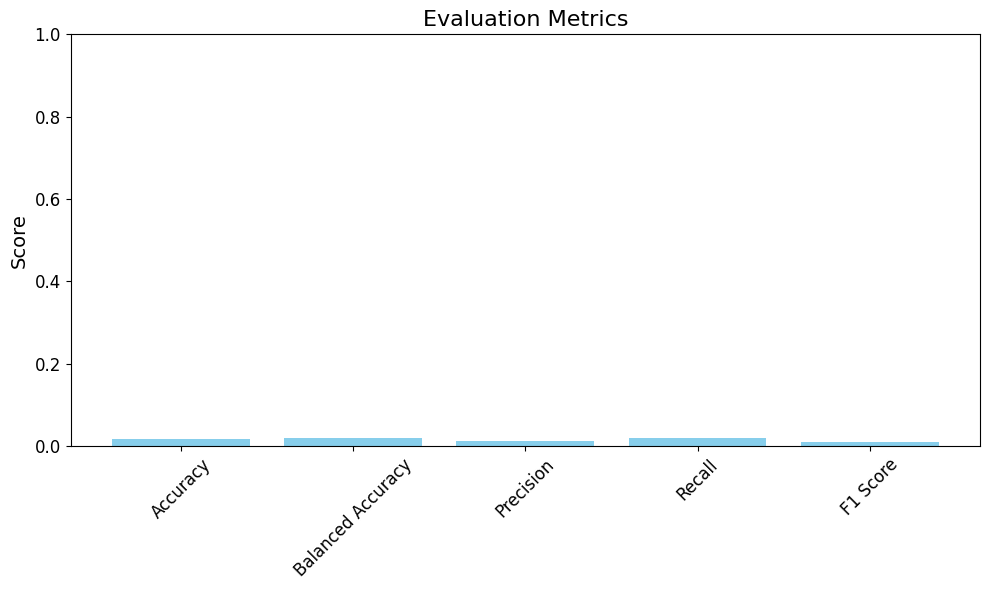

In [ ]:
# Define evaluation metrics
metrics = {
    'Accuracy': accuracy,
    'Balanced Accuracy': balanced_accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# Plot evaluation metrics using a bar chart
plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color='skyblue')
plt.title('Evaluation Metrics', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.ylim(0.0, 1.0)  # Set y-axis limits based on metric scale
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRV1FUV/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRV1FUV/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10
187/187 [==============================] - 151s 706ms/step - loss: 5.0733 - accuracy: 0.0379 - val_loss: 3.7403 - val_accuracy: 0.1953
Epoch 2/10
187/187 [==============================] - 133s 709ms/step - loss: 3.7927 - accuracy: 0.1601 - val_loss: 2.4413 - val_accuracy: 0.4424
Epoch 3/10
187/187 [==============================] - 132s 706ms/step - loss: 3.0674 - accuracy: 0.2655 - val_loss: 1.7269 - val_accuracy: 0.5791
Epoch 4/10
187/187 [==============================] - 128s 682ms/step - loss: 2.6805 - accuracy: 0.3346 - val_loss: 1.3616 - val_accuracy: 0.6522
Epoch 5/10
187/187 [==============================] - 127s 681ms/step - loss: 2.3935 - accuracy: 0.3883 - val_loss: 1.1424 - val_accuracy: 0.6986
Epoch 6/10
187/187 [==============================] - 128s 682ms/step 

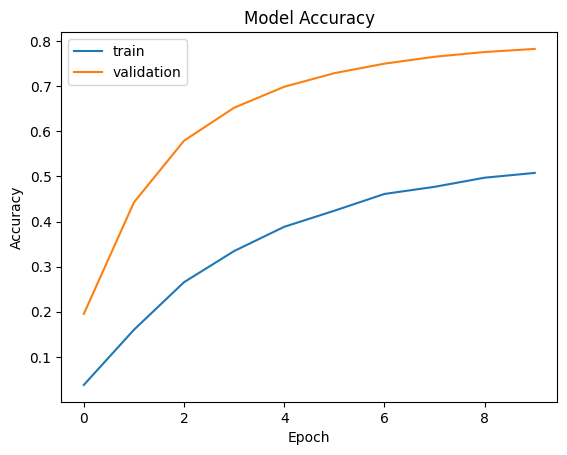

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

# Constants
IMG_SIZE = 224
BATCH_SIZE = 64
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

# Data preprocessing
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

# Data augmentation
img_augmentation_layers = [
    layers.RandomRotation(factor=0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.2),
]

def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

# One-hot encoding and preprocessing functions
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Apply preprocessing functions to datasets
ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Function to build model
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.3  # Adjust dropout rate
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)  # Adjust learning rate
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# Build and train the model
model = build_model(num_classes=NUM_CLASSES)
epochs = 10
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

# Plot training history
plt.plot(hist.history["accuracy"], label="train")
plt.plot(hist.history["val_accuracy"], label="validation")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
